In [1]:
#@title Import packages
# The C2QA pacakge is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
# module_path = os.path.abspath(os.path.join("../.."))
module_path = os.path.abspath(os.path.join("../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

import math
from scipy.linalg import expm, sqrtm
import c2qa
import c2qa.util as util
import qiskit
import numpy as np
import c2qa.util as util
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse.linalg as LA
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer.library import SaveDensityMatrix
from qiskit_aer.noise import NoiseModel, mixed_unitary_error, phase_amplitude_damping_error, amplitude_damping_error, kraus_error

In [2]:
#@title This is the TEST part, only need to run once
qmr_test = c2qa.QumodeRegister(4, num_qubits_per_qumode = 2)
circuit_test = c2qa.CVCircuit(qmr_test)

circuit_test.cv_r(-4.79e12,qmr_test[0])
circuit_test.cv_r(-4.8e12,qmr_test[1])
circuit_test.cv_r(-4.79e12,qmr_test[2])
circuit_test.cv_r(-6e11,qmr_test[3])

_, result, _ = util.simulate(circuit_test)

c:\Users\danie\.conda\envs\python3.10\lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [3]:
#@title Circuit parameters
global numberofmodes, numberofqubitspermode, cutoff
numberofmodes=4         # Number of qumodes in the simulation
numberofqubitspermode=2 # Number of qubits for each qumode. Fock level = 2^(#qubits)
cutoff=2**numberofqubitspermode

## Simulation parameters
sim_steps = 201          # The number of steps in the trotter simulation
timestep = 0.01          # The timestep for the trotter simulation
shots = 10000             # Number of shots to run the simulation for - necessary only for damping channels
amplitude_damping = True # Toggles on or off the amplitude damping channel
dephasing = True         # Toggles on or off the dephasing channel
time = np.round(np.arange(sim_steps) * timestep, 5)

In [4]:
#@title Global parameters

## Damping rates; damping probability = sin(theta/2)^2 = (gamma_all*timestep)
# Amplitude Damping Rate and conversion to theta
gamma_damp = np.array([3.15e12/1e12, 3.15e12/1e12, 3.15e12/1e12]) # [gamma_a, gamma_b, gamma_c, gamma_l]
theta_damp = 2*np.arcsin(np.sqrt(gamma_damp*timestep))
# Dephasing Rate and conversion to theta
gamma_dephase = np.array([9.0e11/1e12, 9.0e11/1e12, 9.0e11/1e12]) # [gamma_a, gamma_b, gamma_c, gamma_l]
theta_dephase = 2*np.arcsin(np.sqrt(gamma_dephase*timestep))

# Global parameters
omega = np.array([4.79e13, 4.8e13, 4.785e13, 6e12])/1e12 # omega_a,b,c,l
delta_qa = np.array([5.00400599e11, 4.99487607e10])/1e12            # delta_ab,ac
chi = np.array([-3.2e12, -3.6e12, -2.7e12])/1e12         # chi_a,b,c
g_cd = np.array([3.38326237e12, 3.03151748e12, 3.70349480e12])/1e12    # g_cda,cdb,cdc
g_cdl = (1.341640786499e12+0.0j)/1e12                            # g_cdl
g_a = np.array([3e12, 2.7e12])/1e12                      # g_ab,ac
g_al = np.array([-3e11, 4.05e11])/1e12                   # g_abl,acl

In [5]:
#@title Build circuit for $\exp{(-iH_0\tau)}$ Needs trotterization.
def H0(tau, omega_list=omega, delta_list=delta_qa, reverse = False):
    omega_t = -tau*omega_list
    delta_t = -tau*delta_list
    if not reverse:
        for i_qumode in range(numberofmodes):
            circuit.cv_r(omega_t[i_qumode], qmr[i_qumode])
        for i_qumode in range(1,numberofmodes-1):
            circuit.rz(delta_t[i_qumode-1], qbr[i_qumode])
    else:
        for i_qumode in range(1,numberofmodes-1):
            circuit.rz(delta_t[i_qumode-1], qbr[i_qumode])
        for i_qumode in range(numberofmodes):
            circuit.cv_r(omega_t[i_qumode], qmr[i_qumode])
    circuit.barrier()

In [6]:
#@title Build circuit for $\exp{(-iH_1\tau)}$
def H1(tau, chi_list = chi, g_cd_list = g_cd, reverse = False):
    chi_t = tau*chi_list/(2)
    g_cdt = tau*g_cd_list/(2)*1j*(-1)
    if not reverse:
        for i_qumode in range(numberofmodes-1):
            circuit.cv_c_r(chi_t[i_qumode], qmr[i_qumode], qbr[i_qumode])
            circuit.cv_c_d(g_cdt[i_qumode], qmr[i_qumode], qbr[i_qumode])
    else:
        for i_qumode in range(numberofmodes-1):
            r_i_qumode = numberofmodes-2-i_qumode #reverse index
            circuit.cv_c_d(g_cdt[r_i_qumode], qmr[r_i_qumode], qbr[r_i_qumode])
            circuit.cv_c_r(chi_t[r_i_qumode], qmr[r_i_qumode], qbr[r_i_qumode])
    circuit.barrier()

In [7]:
#@title Build circuit for $\exp{(-iH_2\tau)}$ Rotated version: Split H2XX and H2YY
def H2XX(tau, g_cdl=g_cdl, g_a_list=g_a, g_al_list=g_al, reverse = False):
    g_at = 2*tau*g_a_list
    g_alt = -1j*tau*g_al_list
    if not reverse:
        for i_qumode in range(2): # ab and ac
            circuit.rxx(g_at[i_qumode]/2, qbr[0], qbr[1+i_qumode])

        # Displaced qb for l controlled by sigma_a^x
        circuit.swap(qbr[0], anc[0])
        circuit.cv_c_d(-1j*g_cdl*tau/(4), qmr[3], anc[0])
        circuit.swap(qbr[0], anc[0])
        circuit.barrier()

        # Displaced qb for l controlle by sigma_a^x*sigma_(b or c)^x
        for i_qumode in range(1,3):
            circuit.h(qbr[0])
            circuit.h(qbr[i_qumode])
            circuit.cx(qbr[i_qumode], qbr[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cv_c_d(g_alt[i_qumode-1]/2, qmr[3], anc[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cx(qbr[i_qumode], qbr[0])
            circuit.h(qbr[0])
            circuit.h(qbr[i_qumode])
            circuit.barrier()
    else:
        # Displaced qb for l controlle by sigma_a^x*sigma_(b or c)^x
        for i_qumode in range(1,3):
            r_i_qumode = numberofmodes-1-i_qumode # reverse index
            circuit.h(qbr[0])
            circuit.h(qbr[r_i_qumode])
            circuit.cx(qbr[r_i_qumode], qbr[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cv_c_d(g_alt[-i_qumode]/2, qmr[3], anc[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cx(qbr[r_i_qumode], qbr[0])
            circuit.h(qbr[0])
            circuit.h(qbr[r_i_qumode])
            circuit.barrier()

        # Displaced qb for l controlled by sigma_a^x
        circuit.swap(qbr[0], anc[0])
        circuit.cv_c_d(-1j*g_cdl*tau/(4), qmr[3], anc[0])
        circuit.swap(qbr[0], anc[0])
        circuit.barrier()

        for i_qumode in range(2): # ab and ac
            r_i_qumode = 1-i_qumode # reverse index
            circuit.rxx(g_at[-i_qumode-1]/2, qbr[0], qbr[1+r_i_qumode])

def H2YY(tau, g_cdl=g_cdl, g_a_list=g_a, g_al_list=g_al, reverse = False):
    g_at = 2*tau*g_a_list
    g_alt = -1j*tau*g_al_list
    if not reverse:
        for i_qumode in range(2): # ab and ac
            circuit.ryy(g_at[i_qumode]/2, qbr[0], qbr[1+i_qumode])

        # Displaced qb for l controlled by sigma_a^x
        circuit.swap(qbr[0], anc[0])
        circuit.cv_c_d(-1j*g_cdl*tau/(4), qmr[3], anc[0])
        circuit.swap(qbr[0], anc[0])
        circuit.barrier()

        # Displaced qb for l controlled by sigma_a^x*sigma_(b or c)^x
        for i_qumode in range(1,3):
            circuit.rz(-np.pi/2,qbr[0])
            circuit.h(qbr[0])
            circuit.rz(-np.pi/2,qbr[i_qumode])
            circuit.h(qbr[i_qumode])
            circuit.cx(qbr[i_qumode], qbr[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cv_c_d(g_alt[i_qumode-1]/2, qmr[3], anc[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cx(qbr[i_qumode], qbr[0])
            circuit.h(qbr[0])
            circuit.rz(np.pi/2,qbr[0])
            circuit.h(qbr[i_qumode])
            circuit.rz(np.pi/2,qbr[i_qumode])
            circuit.barrier()
    else:
        # Displaced qb for l controlle by sigma_a^x*sigma_(b or c)^x
        for i_qumode in range(1,3):
            r_i_qumode = numberofmodes-1-i_qumode # reverse index
            circuit.rz(np.pi/2,qbr[0])
            circuit.h(qbr[0])
            circuit.rz(np.pi/2,qbr[r_i_qumode])
            circuit.h(qbr[r_i_qumode])
            circuit.cx(qbr[r_i_qumode], qbr[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cv_c_d(g_alt[-i_qumode]/2, qmr[3], anc[0])
            circuit.swap(qbr[0], anc[0])
            circuit.cx(qbr[r_i_qumode], qbr[0])
            circuit.h(qbr[0])
            circuit.rz(-np.pi/2,qbr[0])
            circuit.h(qbr[r_i_qumode])
            circuit.rz(-np.pi/2,qbr[r_i_qumode])
            circuit.barrier()

        # Displaced qb for l controlled by sigma_a^x
        circuit.swap(qbr[0], anc[0])
        circuit.cv_c_d(-1j*g_cdl*tau/(4), qmr[3], anc[0])
        circuit.swap(qbr[0], anc[0])
        circuit.barrier()

        for i_qumode in range(2): # ab and ac
            r_i_qumode = 1-i_qumode # reverse index
            circuit.ryy(g_at[-i_qumode-1]/2, qbr[0], qbr[1+r_i_qumode])

c:\Users\danie\.conda\envs\python3.10\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\danie\AppData\Local\Temp\ipykernel_58928\3138382746.py:69: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


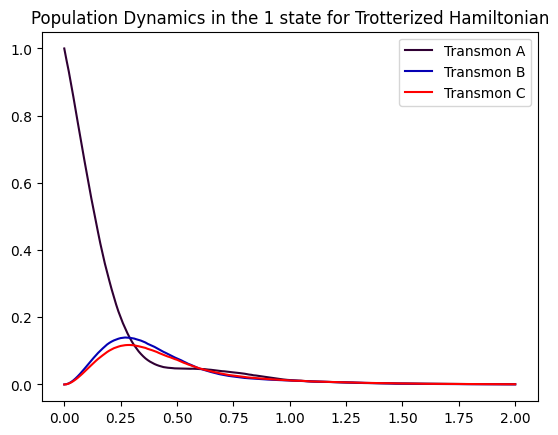

In [8]:
#@title Only Lindbladian amplitude damping
# Build circuit and do loop
from qiskit.quantum_info import DensityMatrix, partial_trace
from tqdm import tqdm

rho_A = []
rho_B = []
rho_C = []

## Initializes circuit
qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = QuantumRegister(size = numberofmodes-1)
anc = QuantumRegister(size = 1)
cbits = ClassicalRegister(size = numberofmodes)
circuit = c2qa.CVCircuit(qmr, qbr, anc, cbits)
circuit.x(qbr[0])

## Build trotter simulation
for i in range(sim_steps):
    if i != 0:
        H0(timestep/2)
        H1(timestep/2)
        H2XX(timestep/2)
        H2YY(timestep/2)
        H2YY(timestep/2, reverse = True)
        H2XX(timestep/2, reverse = True)
        H1(timestep/2, reverse = True)
        H0(timestep/2, reverse = True)
        # Amplitude damping channel inspired by https://arxiv.org/pdf/2302.14592.pdf (Fig 8)
        idx_damp = 3
        if (amplitude_damping):
            for idx_qb in range(numberofmodes - 1):
                circuit.cry(theta_damp[idx_qb], qbr[idx_qb], anc[0])
                circuit.cx(anc[0], qbr[idx_qb])
                circuit.measure(anc[0], cbits[idx_damp])
                circuit.reset(anc[0])
        # Dephasing Channel
        if (dephasing):
            for idx_qb in range(numberofmodes - 1):
                circuit.ry(-theta_dephase[idx_qb], anc[0])
                circuit.z(anc[0])
                circuit.cz(qbr[idx_qb], anc[0])
                circuit.measure(anc[0], cbits[idx_damp])
                circuit.reset(anc[0])

    # We are able dramatically improve run times by saving the density matrix after every trotter step
    save_densitymatrix = SaveDensityMatrix(1, label='densitymatrix_a{}'.format(i))
    circuit.append(save_densitymatrix, [qbr[0]])
    save_densitymatrix = SaveDensityMatrix(1, label='densitymatrix_b{}'.format(i))
    circuit.append(save_densitymatrix, [qbr[1]])
    save_densitymatrix = SaveDensityMatrix(1, label='densitymatrix_c{}'.format(i))
    circuit.append(save_densitymatrix, [qbr[2]])

## Simulate Circuit and obtain output data
stateop, result, _ = c2qa.util.simulate(circuit, shots=shots)
data = result.data()

for i in range(sim_steps):
    rho_A.append(np.asarray(data['densitymatrix_a{}'.format(i)])[1,1])
    rho_B.append(np.asarray(data['densitymatrix_b{}'.format(i)])[1,1])
    rho_C.append(np.asarray(data['densitymatrix_c{}'.format(i)])[1,1])

fig, ax = plt.subplots()
ax.set_title('Population Dynamics in the 1 state for Trotterized Hamiltonian')
ax.plot(time, rho_A, '#2F0033')
ax.plot(time, rho_B, '#0500B4')
ax.plot(time, rho_C, '#FF0000')
ax.legend(['Transmon A', 'Transmon B', 'Transmon C'])
fig.show()

In [9]:
np.savez('New_Lindbladian_Sim_noCDnoisy.npz', time, rho_A, rho_B, rho_C)
[sum(x) for x in zip(rho_A, rho_B, rho_C)]

[(1+0j),
 (0.9666000000008003+0j),
 (0.9379000000034436+0j),
 (0.9080000000084766+0j),
 (0.8794000000163651+0j),
 (0.8519000000272411+0j),
 (0.8238000000421168+0j),
 (0.7980000000606301+0j),
 (0.7747000000833767+0j),
 (0.7497000001109543+0j),
 (0.727200000142173+0j),
 (0.7056000001786086+0j),
 (0.682800000221813+0j),
 (0.6628000002678837+0j),
 (0.6420000003179993+0j),
 (0.6221000003740345+0j),
 (0.6013000004352319+0j),
 (0.5827000005024164+0j),
 (0.5646000005702091+0j),
 (0.5497000006416313+0j),
 (0.5330000007179271+0j),
 (0.5157000007991238+0j),
 (0.500100000882016+0j),
 (0.48200000097100526+0j),
 (0.4665000010594056+0j),
 (0.4525000011493898+0j),
 (0.4375000012431478+0j),
 (0.42430000133631185+0j),
 (0.4096000014331898+0j),
 (0.396000001528113+0j),
 (0.3823000016217884+0j),
 (0.37010000172018576+0j),
 (0.35680000182965893+0j),
 (0.34480000192702764+0j),
 (0.3334000020215818+0j),
 (0.3222000021156057+0j),
 (0.3115000022171144+0j),
 (0.2997000023006609+0j),
 (0.29020000237720844+0j),
 

In [10]:
#@title Build CD noise model
def sigmaz_np():
    return np.array([[1, 0 + 1j*0], [0, -1]])
def destroy_np(N):
    op = np.diag(np.sqrt(np.arange(1, N)), k=1)
    return op
def create_np(N):
    return np.conj(destroy_np(N)).T
def numberop_np(N):
    return create_np(N) * destroy_np(N)

def kraus_amplitude_damping_cavity(N, l, kappa, tau = 1e-14): # implement eq (B3) from Yuan's hybrid paper
    # since N is finite, l > 0 in this function
    coeff = np.sqrt((1-np.exp(-kappa*tau)) ** l / math.factorial(l))
    return coeff * expm(-kappa/2*tau*numberop_np(N)) * np.linalg.matrix_power(destroy_np(N), l)

def add_CDnoise(noise_m, kappa_1c, kappa_1q, kappa_pq, label, alpha, chi = 1e5*np.pi, tau = 1e-14):
    kappa_1c_rescaled = kappa_1c * g_cdl * 1e12 / (2*alpha*chi)
    allKs = []
    sumKi_larger0 = 0
    for i in range(cutoff):
        Ki = kraus_amplitude_damping_cavity(cutoff, i, kappa_1c_rescaled)
        allKs.append(Ki)
        if i > 0:
            sumKi_larger0 += np.matmul(Ki, Ki.conj().T)
    allKs[0] = sqrtm(np.eye(cutoff) - sumKi_larger0)
    errorcavity = kraus_error(allKs)
    qb_amp_rate = np.real(kappa_1q * (g_cdl*1e12) * tau / (2*alpha*chi))
    qb_dp_rate = np.real(kappa_pq * (g_cdl*1e12) * tau / (2*alpha*chi))
    print(f"Qubit amp damping prob: {qb_amp_rate} and dephasing prob {qb_dp_rate}: ")
    #errorgate = errorcavity.tensor(phase_amplitude_damping_error(param_amp = qb_amp_rate, param_phase = qb_dp_rate))
    errorgate = phase_amplitude_damping_error(param_amp = qb_amp_rate, param_phase = qb_dp_rate).tensor(errorcavity)
    noise_m.add_all_qubit_quantum_error(errorgate, label)

Qubit amp damping prob: 7.117625434167136e-06 and dephasing prob 3.558812717083568e-06: 


C:\Users\danie\AppData\Local\Temp\ipykernel_58928\3419720564.py:76: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_n1.show()


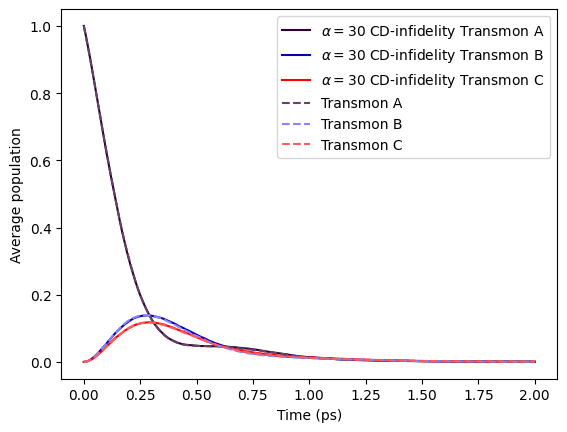

In [11]:
#@title Noise from CD gate for alpha = 30

noise_model1 = NoiseModel()
noise_model1.add_basis_gates(['unitary'])
add_CDnoise(noise_model1, 1e3, 1e4, 5e3, 'cD', 30)

# Build circuit and do loop

rho_A_n1 = []
rho_B_n1 = []
rho_C_n1 = []

## Initializes circuit
qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = QuantumRegister(size = numberofmodes-1)
anc = QuantumRegister(size = 1)
cbits = ClassicalRegister(size = numberofmodes)
circuit = c2qa.CVCircuit(qmr, qbr, anc, cbits)
circuit.x(qbr[0])

## Build trotter simulation
for i in range(sim_steps):
    if i != 0:
        H0(timestep/2)
        H1(timestep/2)
        H2XX(timestep/2)
        H2YY(timestep/2)
        H2YY(timestep/2, reverse = True)
        H2XX(timestep/2, reverse = True)
        H1(timestep/2, reverse = True)
        H0(timestep/2, reverse = True)
        # Amplitude damping channel inspired by https://arxiv.org/pdf/2302.14592.pdf (Fig 8)
        idx_damp = 3
        if (amplitude_damping):
            for idx_qb in range(numberofmodes - 1):
                circuit.cry(theta_damp[idx_qb], qbr[idx_qb], anc[0])
                circuit.cx(anc[0], qbr[idx_qb])
                circuit.measure(anc[0], cbits[idx_damp])
                circuit.reset(anc[0])
        # Dephasing Channel
        if (dephasing):
            for idx_qb in range(numberofmodes - 1):
                circuit.ry(-theta_dephase[idx_qb], anc[0])
                circuit.z(anc[0])
                circuit.cz(qbr[idx_qb], anc[0])
                circuit.measure(anc[0], cbits[idx_damp])
                circuit.reset(anc[0])

    # We are able dramatically improve run times by saving the density matrix after every trotter step
    save_densitymatrix = SaveDensityMatrix(1, label='densitymatrix_a{}'.format(i))
    circuit.append(save_densitymatrix, [qbr[0]])
    save_densitymatrix = SaveDensityMatrix(1, label='densitymatrix_b{}'.format(i))
    circuit.append(save_densitymatrix, [qbr[1]])
    save_densitymatrix = SaveDensityMatrix(1, label='densitymatrix_c{}'.format(i))
    circuit.append(save_densitymatrix, [qbr[2]])

## Simulate Circuit and obtain output data
stateop_n1, result_n1, _ = c2qa.util.simulate(circuit, shots=shots)
data_n1 = result_n1.data()

for i in range(sim_steps):
    rho_A_n1.append(np.asarray(data_n1['densitymatrix_a{}'.format(i)])[1,1])
    rho_B_n1.append(np.asarray(data_n1['densitymatrix_b{}'.format(i)])[1,1])
    rho_C_n1.append(np.asarray(data_n1['densitymatrix_c{}'.format(i)])[1,1])

fig_n1, ax_n1 = plt.subplots()
plt.ylabel('Average population')
plt.xlabel('Time (ps)')
ax_n1.plot(time, rho_A_n1, '#2F0033')
ax_n1.plot(time, rho_B_n1, '#0500B4')
ax_n1.plot(time, rho_C_n1, '#FF0000')
ax_n1.plot(time, rho_A, '#664169', linestyle='--')
ax_n1.plot(time, rho_B, '#8686FF', linestyle='--')
ax_n1.plot(time, rho_C, '#FF5B5B', linestyle='--')
ax_n1.legend(['$α=30$ CD-infidelity Transmon A', '$α=30$ CD-infidelity Transmon B', '$α=30$ CD-infidelity Transmon C', 'Transmon A', 'Transmon B', 'Transmon C'])
fig_n1.show()

In [12]:
np.savez('New_CDnoisy_30_Sim.npz', time, rho_A_n1, rho_B_n1, rho_C_n1)
[sum(x) for x in zip(rho_A_n1, rho_B_n1, rho_C_n1)]

[(1+0j),
 (0.9699000000008002+0j),
 (0.9386000000037092+0j),
 (0.9091000000085361+0j),
 (0.8800000000164696+0j),
 (0.852600000027782+0j),
 (0.8248000000425959+0j),
 (0.798700000061713+0j),
 (0.7747000000860298+0j),
 (0.7483000001133341+0j),
 (0.7239000001451589+0j),
 (0.7042000001818182+0j),
 (0.6818000002237079+0j),
 (0.6625000002699255+0j),
 (0.6450000003204841+0j),
 (0.6220000003766488+0j),
 (0.5994000004383514+0j),
 (0.5795000005027453+0j),
 (0.5626000005700388+0j),
 (0.5435000006462274+0j),
 (0.5270000007245242+0j),
 (0.5104000008045113+0j),
 (0.4966000008829864+0j),
 (0.4800000009690915+0j),
 (0.46450000105684175+0j),
 (0.44900000114946625+0j),
 (0.4363000012416735+0j),
 (0.4221000013357863+0j),
 (0.4088000014293833+0j),
 (0.3967000015218965+0j),
 (0.38310000162143404+0j),
 (0.3685000017152289+0j),
 (0.35880000181128036+0j),
 (0.3464000019071226+0j),
 (0.3366000019930338+0j),
 (0.326600002077748+0j),
 (0.315600002180077+0j),
 (0.30430000226991916+0j),
 (0.2951000023629376+0j),
 (